In [6]:
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import numpy as np
from notebooks import utils

<h1>Selecting features</h1>

We have seen that the platform type is a strong indicator for the amount of money people are willing to spend on in-game purchases. But this surely won't be the only indicator. In this section we will select three different features and use them in a K-means algorithm to find different groups of players and their relation to in-game purchases.

The following features are selected:
<ul class="simple">
<li> revenuePerTeam &nbsp;&emsp;            [sum(price) group by team]</li>
<li> strengthLevelRatio&emsp;                  [strength/currentLevel] </li>
<li> teamLifeSpan &emsp;&emsp;&nbsp;&emsp;[teamEndTime - teamCreationTime] </li>

First, we will load the .csv files containing the buy-clicks data and the team data.

In [10]:
sqlContext = SQLContext(sc)

buyData = sqlContext.read.load('file:///home/cloudera/courseraDataSimulation-master/capstone/readings/flamingo-data/buy-clicks.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')
teamData = sqlContext.read.load('file:///home/cloudera/courseraDataSimulation-master/capstone/readings/flamingo-data/team.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

Next, the total spendings of each team is determined and stored in a new dataframe. Also, the column are renamed.

In [11]:
subData = buyData.groupBy("team").agg(sum("price"))
subData = subData.withColumnRenamed('sum(price)', 'revenuePerTeam')
subData = subData.withColumnRenamed('team', 'teamId')
subData.sort("teamId").show(5)

+------+--------------+
|teamId|revenuePerTeam|
+------+--------------+
|     2|         178.0|
|     8|         382.0|
|     9|         513.0|
|    11|         587.0|
|    13|         448.0|
+------+--------------+
only showing top 5 rows



Similarly, we combine the required information and select only the required columns.

In [12]:
teamLifeSpan_col = col("teamEndTime").cast("long") - col("teamCreationTime").cast("long")
strengthLevelRatio_col = col("strength") / col("currentLevel")

teamData = teamData.withColumn("teamLifeSpan", teamLifeSpan_col)
teamData = teamData.withColumn("strengthLevelRatio", strengthLevelRatio_col)
teamData = teamData.select("teamId", "teamLifeSpan", "strengthLevelRatio")
teamData.sort("teamId").show(5)

+------+------------+------------------+
|teamId|teamLifeSpan|strengthLevelRatio|
+------+------------+------------------+
|     0|251936371622|    0.174879834235|
|     1|251936476747|    0.105268242757|
|     2|251936415414|    0.146636553695|
|     3|251936415851|    0.575897759388|
|     4|251936344891|    0.134574686618|
+------+------------+------------------+
only showing top 5 rows



<h2> Joining dataframes </h2>
Join both dataframes and select only the required column. For all teams that have done no in-game purchases a value of 0 will be inserted in the revenuePerTeam column.

In [13]:
workingDat = teamData.join(subData, on=['teamId'], how='outer').select("teamLifeSpan", "strengthLevelRatio", "revenuePerTeam")
workingDat = workingDat.na.fill(0)

The remaining dataframe has the following dimensions.

In [104]:
print(workingDat.count(), "rows and", len(workingDat.columns), "columns")

169 rows and 3 columns


In [46]:
workingDat.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
teamLifeSpan,169,1.535470142469586E11,1.2327739042364684E11,0,251936558792
strengthLevelRatio,169,0.31185658308037445,0.32222852216250214,0.0,0.994851162257
revenuePerTeam,169,126.66863905325444,190.1401338453616,0.0,880.0


<h1> Determining the number of clusters </h1>

In [14]:
featuresUsed = ["teamLifeSpan", "strengthLevelRatio", "revenuePerTeam"]
assembler = VectorAssembler(inputCols=featuresUsed, outputCol='features_unscaled')
assembled = assembler.transform(workingDat)

In [15]:
scaler = StandardScaler(inputCol='features_unscaled', outputCol='features', withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)
scaledData = scaledData.select("features")
scaledData.persist()

DataFrame[features: vector]

In [17]:
clusters = range(2, 20)
wsseList = utils.elbow(scaledData, clusters)

Training for cluster size 2 
......................WSSE = 162.71608681733414 
Training for cluster size 3 
......................WSSE = 117.3389903038978 
Training for cluster size 4 
......................WSSE = 103.79885169168118 
Training for cluster size 5 
......................WSSE = 87.14623199500267 
Training for cluster size 6 
......................WSSE = 79.62310516971975 
Training for cluster size 7 
......................WSSE = 77.9574055370857 
Training for cluster size 8 
......................WSSE = 70.02664083933175 
Training for cluster size 9 
......................WSSE = 62.85090018182764 
Training for cluster size 10 
......................WSSE = 55.34632249176005 
Training for cluster size 11 
......................WSSE = 50.84824638984663 
Training for cluster size 12 
......................WSSE = 49.88526301665293 
Training for cluster size 13 
......................WSSE = 49.873920298234125 
Training for cluster size 14 
......................WSSE = 49.32388415

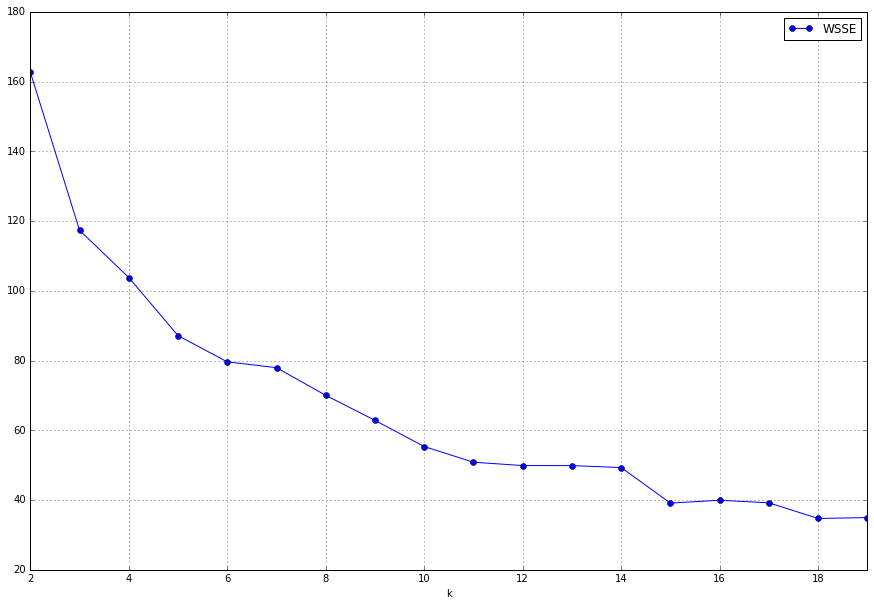

In [18]:
utils.elbow_plot(wsseList, clusters)

In [20]:
kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(scaledData)
transformed = model.transform(scaledData)

In [22]:
centers = model.clusterCenters()
centers

[array([ 0.79811356, -0.09910393,  2.27760802]),
 array([-1.24554073, -0.93950776, -0.26919232]),
 array([ 0.79811345, -0.02803835, -0.51249789]),
 array([ 0.79811367,  1.34517521,  1.47997576]),
 array([ 0.66626475,  1.42078479, -0.47074411])]

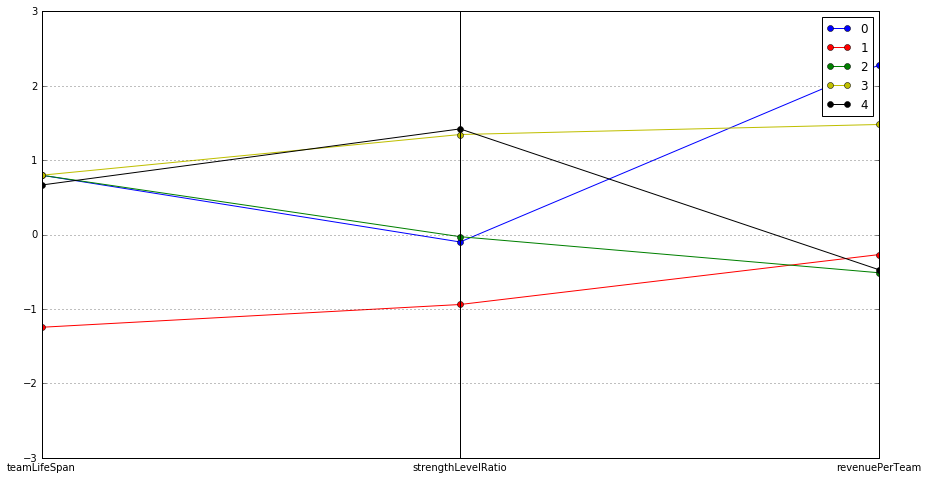

In [24]:
p = utils.pd_centers(featuresUsed, centers)
utils.parallel_plot(p,p)

In [45]:
scaledData.show(5, False)

+-----------------------------------------------------------+
|features                                                   |
+-----------------------------------------------------------+
|[0.7981126470549348,1.8683210268022752,-0.6661857046775425]|
|[0.79811440149668,-0.10903229119071133,0.07537262468954091]|
|[0.7981134832179948,1.7257201329812526,-0.6661857046775425]|
|[0.7981124992338304,1.0075422587355498,-0.6661857046775425]|
|[0.7981140720688761,1.6268110224931158,3.067902336816281]  |
+-----------------------------------------------------------+
only showing top 5 rows

